In [17]:
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset

import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [18]:
df = pd.read_csv("final_df.csv", index_col = 0, parse_dates = True)

The bottom chunk was run on 04/08/2024 and reflect these weights. these are updated daily

In [4]:
import pandas as pd
import requests

weights_df = pd.read_html(requests.get('https://www.slickcharts.com/sp500',
                      headers={'User-agent': 'Mozilla/5.0'}).text)[0]

weights_df.to_csv('weights.csv',index=False)

In [19]:
weights_df = pd.read_csv('weights.csv')
weights = weights_df[['Symbol', 'Portfolio%']]

In [20]:
import pandas as pd

# Assuming your DataFrames are named weights and df
# Get the list of stock symbols from df columns
stock_symbols = list(df.columns)

# Filter weights based on stock symbols in the portfolio
weights_filtered = weights[weights['Symbol'].isin(stock_symbols)].copy()  # Use .copy() to avoid warnings on a slice

# Ensure weights_filtered has a 'weights' column (if not present)
if 'weights' not in weights_filtered.columns:
    weights_filtered['weights'] = pd.Series(dtype=float)  # Initialize an empty float column

# Convert weights from percentages to numeric values and normalize
weights_filtered.loc[:, 'weights'] = weights_filtered['Portfolio%'].str.rstrip('%').astype(float) / 100
weights_filtered.loc[:, 'weights'] = weights_filtered['weights'] / weights_filtered['weights'].sum()

# Create a DataFrame with symbols and weights
final_weights_df = pd.DataFrame({'Symbol': weights_filtered['Symbol'], 'weights': weights_filtered['weights']})

In [21]:
missing_symbols = set(stock_symbols) -  set(weights_filtered['Symbol'])
df = df.drop(missing_symbols, axis=1)

In [22]:
log_returns = np.log(df / df.shift(1))
log_returns = log_returns.dropna()

In [23]:
rolling_window_size = 180

# Calculate rolling mean and standard deviation for each stock
rolling_mean = log_returns.rolling(window=rolling_window_size).mean()
rolling_std = log_returns.rolling(window=rolling_window_size).std()

# Standardize the log returns
standardized_log_returns = (log_returns - rolling_mean) / rolling_std

# Optional: Drop the initial rows where the rolling mean and std are NaN
# This will happen for the first (rolling_window_size - 1) days
standardized_log_returns = standardized_log_returns.dropna(how='all')

In [24]:
# Ensure the order of final_weights_df matches the columns in log_returns
final_weights_df_sorted = final_weights_df.set_index('Symbol').reindex(log_returns.columns).reset_index()

# Extract the weights into a NumPy array, now aligned with the log_returns columns
weights_vector = final_weights_df_sorted['weights'].values

# Convert log_returns DataFrame to a NumPy array
log_returns_matrix = log_returns.values

# Calculate portfolio returns
portfolio_returns = np.dot(log_returns_matrix, weights_vector)

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis

# Calculate kurtosis using scipy (excess kurtosis, Fisher's definition, subtracts 3)
portfolio_kurtosis = kurtosis(portfolio_returns, fisher=True)

# Calculate kurtosis using pandas (excess kurtosis by default)
# portfolio_kurtosis = portfolio_returns.kurt()

print(f"Portfolio Kurtosis: {portfolio_kurtosis}")


Portfolio Kurtosis: 11.21505958977071


In [11]:
from scipy.stats import jarque_bera

# Perform the Jarque-Bera test
jb_stat, p_value = jarque_bera(portfolio_returns)

print(f"Jarque-Bera statistic: {jb_stat}, p-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("The null hypothesis can be rejected. The data does not follow a normal distribution.")
else:
    print("The null hypothesis cannot be rejected. The data may follow a normal distribution.")

Jarque-Bera statistic: 27835.055814728916, p-value: 0.0
The null hypothesis can be rejected. The data does not follow a normal distribution.


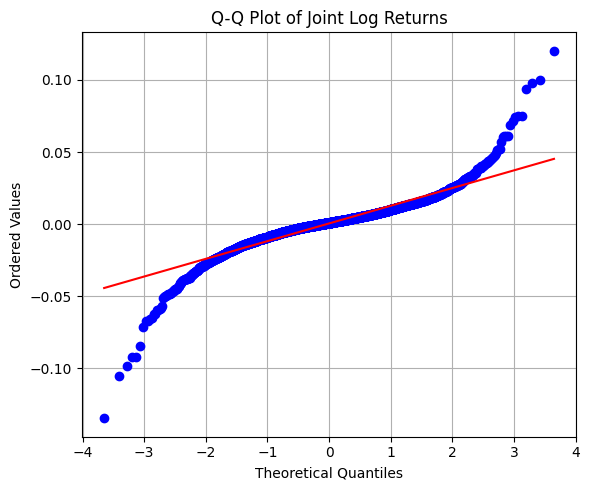

In [230]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing log returns with assets as columns and dates as rows

# Calculate the joint log returns by summing across the columns for each row

fig, ax = plt.subplots(figsize=(6, 5))  # Set the figure size
stats.probplot(portfolio_returns, dist="norm", plot=ax)

ax.set_title('Q-Q Plot of Joint Log Returns')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Ordered Values')
ax.grid(True)
plt.tight_layout()
#plt.savefig('qq_plot_joint_log_returns.png', dpi=300)  # Save the figure
plt.show()

In [25]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [26]:
device

device(type='cuda')

In [27]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np

# Assuming standardized_log_returns is already defined and 'device' is set
batch_size = standardized_log_returns.shape[1]  # Number of columns (stocks)

# Calculate the indices for splitting without needing to adjust for batch size
train_end = int(len(standardized_log_returns) * 0.75)
val_end = int(len(standardized_log_returns) * 0.875)
test_end = len(standardized_log_returns)

# Split the data
train_data = standardized_log_returns.iloc[:train_end]
validation_data = standardized_log_returns.iloc[train_end:val_end]
test_data = standardized_log_returns.iloc[val_end:test_end]

# Function to convert DataFrame into a 2D PyTorch tensor with shape (days, stocks)
def df_to_2d_tensor(df):
    tensor = torch.tensor(df.values, dtype=torch.float32).to(device)  # Convert to tensor and send to device
    return tensor

# Convert each DataFrame into a 2D tensor
train_tensor = df_to_2d_tensor(train_data)
validation_tensor = df_to_2d_tensor(validation_data)
test_tensor = df_to_2d_tensor(test_data)  # Note: Adjustments for perfect batches are not needed here

# Create TensorDatasets
train_dataset = TensorDataset(train_tensor)
validation_dataset = TensorDataset(validation_tensor)
test_dataset = TensorDataset(test_tensor)

# Create DataLoader instances
# Note: Each item in the dataset is now a tensor representing a day's returns across all stocks,
# so the DataLoader will naturally iterate through days, with each batch containing all stocks' returns for a given day
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)  # Batch size is 1 since each item is a day
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Note: The DataLoader batch size is set to 1 because each tensor in the dataset already represents
# all stocks for a single day. Setting shuffle=False to maintain chronological order.


In [39]:
# Sanity Check

# Print the first tensor in train_tensor
print("First tensor in train_tensor:")
print(train_tensor[0])  # The first day's returns across all stocks
print("\n")

# Print the first row in train_dataset
print("First row in train_dataset:")
# Since each item in the dataset is a tensor representing all stocks' returns for a day,
# and train_dataset is a TensorDataset, we access the first item and its first element (the tensor itself)
print(train_dataset[0][0])  # Accessing the first item's tensor
print("\n")

# Print the first batch in train_loader
print("First batch in train_loader:")
for batch in train_loader:
    # Each batch in train_loader is a tuple (data, ), where data is a tensor representing a single day's returns across all stocks
    print(batch[0])  # batch[0] is the tensor for the day, we only need the first batch, so we break after printing it
    break


,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,WYNN,XEL,XOM,YUM,ZBH,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-03,1.798619,1.932653,0.154385,-0.702306,0.953449,0.744020,1.022370,1.659865,-0.109576,0.944209,...,0.807617,-0.801816,0.638859,0.368126,3.369619,0.786500,1.684464,-0.195875,-0.358433,0.304770
2018-12-04,-1.384060,-2.510172,-2.938431,-1.374980,-1.101878,-1.712778,-1.961751,-2.553261,-2.012249,-2.256950,...,-2.320404,-2.168402,-0.940550,-3.631642,-2.805106,-0.290467,-1.811325,-1.355740,-2.700662,-2.472074
2018-12-06,-0.803652,-0.633378,-0.015046,-0.577172,-2.104433,0.846283,-0.584455,-0.201495,-0.305774,0.077445,...,-0.853503,-0.378740,-0.479468,4.272713,0.744473,0.584586,-1.072138,0.728721,0.573227,0.333022
2018-12-07,-1.355933,-2.010790,-1.765677,-0.024857,-0.867181,-2.318954,-2.056387,-2.270635,-2.094497,-2.178570,...,-1.293372,-0.923284,-1.451877,-3.520228,-2.288838,-0.128709,-0.797117,-1.058680,-1.858587,-1.808858
2018-12-10,0.257497,0.356757,0.979051,-0.533377,0.100202,1.092934,1.383400,0.244323,0.112681,0.707291,...,0.566744,-0.758712,0.835123,1.170523,0.511640,0.377765,-1.165753,-0.209982,0.740508,0.578869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-10,1.337496,-0.442789,0.619801,-0.161494,0.432656,2.111670,0.195566,-0.983086,0.497543,0.302689,...,0.504686,-0.146536,1.348863,-1.574424,-0.222835,0.299343,-0.064742,0.680949,0.334533,0.131129
2021-06-11,0.079277,0.453834,-0.163096,0.293690,0.172431,0.537738,-0.034975,-1.371221,-0.318894,-0.059621,...,0.537631,0.395937,0.192977,0.396928,0.148953,-0.123567,-0.523052,0.505362,-0.421072,-0.216736
2021-06-14,0.269232,1.191393,0.298971,-0.316152,-0.006485,1.493279,0.146117,-0.923996,-0.337651,0.467170,...,-0.134769,-0.482648,-0.128057,-1.251215,-0.666273,-0.537214,-0.203877,-1.189862,-0.332228,-0.056989


In [28]:
# Assuming train_data, validation_data, and test_data are your datasets
print("Train Set Shape:", train_data.shape)
print("Validation Set Shape:", validation_data.shape)
print("Test Set Shape:", test_data.shape)

# Assuming your datasets are DataFrame with a DateTimeIndex
print("\nDate Ranges for Each Set:")
print("Training Date Range:", train_data.index.min(), "to", train_data.index.max())
print("Validation Date Range:", validation_data.index.min(), "to", validation_data.index.max())
print("Testing Date Range:", test_data.index.min(), "to", test_data.index.max())

# Ensuring no overlap
assert train_data.index.max() < validation_data.index.min(), "Overlap between train and validation sets!"
assert validation_data.index.max() < test_data.index.min(), "Overlap between validation and test sets!"


Train Set Shape: (3828, 370)
Validation Set Shape: (638, 370)
Test Set Shape: (639, 370)

Date Ranges for Each Set:
Training Date Range: 2003-09-19 00:00:00 to 2018-11-30 00:00:00
Validation Date Range: 2018-12-03 00:00:00 to 2021-06-16 00:00:00
Testing Date Range: 2021-06-17 00:00:00 to 2023-12-29 00:00:00


In [29]:
import torch
from torch import nn
from torch.nn import functional as F


# Encoder Module
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_layer1_dim, hidden_layer2_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_layer1_dim)
        self.fc2 = nn.Linear(hidden_layer1_dim, hidden_layer2_dim)
        self.fc_mean = nn.Linear(hidden_layer2_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_layer2_dim, latent_dim)

    def forward(self, x):
        h = F.gelu(self.fc1(x))
        h = F.gelu(self.fc2(h))
        return self.fc_mean(h), self.fc_logvar(h)
    
# Decoder Module
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_layer1_dim, hidden_layer2_dim, latent_dim):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(latent_dim, hidden_layer2_dim)
        self.fc2 = nn.Linear(hidden_layer2_dim, hidden_layer1_dim)
        self.fc3 = nn.Linear(hidden_layer1_dim, output_dim)

    def forward(self, z):
        h = F.gelu(self.fc1(z))
        h = F.gelu(self.fc2(h))
        return self.fc3(h)
    
# VAE 
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_layer1_dim, hidden_layer2_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_layer1_dim, hidden_layer2_dim, latent_dim)
        self.decoder = Decoder(input_dim, hidden_layer1_dim, hidden_layer2_dim, latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar
def loss_function(recon_x, x, mu, logvar, C):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp())
    return  C * MSE + KLD # there is a weight/regularizer for MSE. We can also penalize KLD instead

# This loss function outputs individual losses too
# def loss_function(recon_x, x, mu, logvar):
#     MSE = F.mse_loss(recon_x, x, reduction='sum')
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return (5 * MSE + KLD), MSE, KLD

In [32]:
# Hyperparameters
input_dim = 370  # Adjust based on number of stocks
 # Adjust based on desired complexity of the latent space
hidden_layer1_dim = 128
hidden_layer2_dim = 64
latent_dim = 32

model = VAE(input_dim, hidden_layer1_dim, hidden_layer2_dim, latent_dim)
optimizer = torch.optim.AdamW(model.parameters(), lr=.0001)
model.to(device)

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=370, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc_mean): Linear(in_features=64, out_features=32, bias=True)
    (fc_logvar): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=32, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=370, bias=True)
  )
)

In [33]:
import datetime
import torch

epochs = 50
best_val_loss = float('inf')  # Initialize best validation loss to infinity
best_epoch = 0  # Initialize best epoch
base_path = "states/"
best_model_path = ""  # Variable to store the path to the best model

train_losses = []
validation_losses = []
C = 5

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        inputs = data[0].to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(inputs)
        loss = loss_function(recon_batch, inputs, mu, logvar, C)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for data in validation_loader:
            inputs = data[0].to(device)
            recon_batch, mu, logvar = model(inputs)
            loss = loss_function(recon_batch, inputs, mu, logvar, C)
            validation_loss += loss.item()
            
    validation_loss /= len(validation_loader)
    validation_losses.append(validation_loss)

    # Check if this is the best model based on validation loss
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        best_epoch = epoch
        best_model_state = model.state_dict()  # Update the best model's state dictionary
        print(f'New best model found at epoch {epoch}')
        
        
        # # Current date and time
        # now = datetime.datetime.now()
        # date_time = now.strftime("%Y%m%d_%H%M%S")  # Format: YYYYMMDD_HHMMSS
        
        # # Combine base path with dynamically generated file name
        # filename = f"{date_time}_epoch{epoch}_model_weights.pth"
        # path = base_path + filename
        
        # # Save the model state
        # torch.save(model.state_dict(), path)
        # print(f'Saved new best model to {path} at epoch {epoch}')
        
        # # Update the best_model_path variable
        # best_model_path = path

    if epoch % 10 == 0:
        print(f'---Epoch: {epoch}---')
        print(f'Training Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}')

New best model found at epoch 0
---Epoch: 0---
Training Loss: 1314.8518, Validation Loss: 1215.7363
New best model found at epoch 1
New best model found at epoch 2
New best model found at epoch 3
New best model found at epoch 4


KeyboardInterrupt: 

In [ ]:
import datetime
import torch

epochs = 50 # the Larger the model, it seems that there is so much data that we don't need to train for too long
best_val_loss = float('inf')  # Initialize best validation loss to infinity
best_epoch = 0  # Initialize best epoch

train_losses = []
validation_losses = []
C = 5

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        inputs = data[0].to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(inputs)
        loss = loss_function(recon_batch, inputs, mu, logvar, C)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for data in validation_loader:
            inputs = data[0].to(device)
            recon_batch, mu, logvar = model(inputs)
            loss = loss_function(recon_batch, inputs, mu, logvar, C)
            validation_loss += loss.item()
            
    validation_loss /= len(validation_loader)
    validation_losses.append(validation_loss)

    # Check if this is the best model based on validation loss
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        best_epoch = epoch
        best_model_state = model.state_dict()  # Update the best model's state dictionary
        print(f'New best model found at epoch {epoch}')

    if epoch % 10 == 0:
        print(f'---Epoch: {epoch}---')
        print(f'Training Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}')

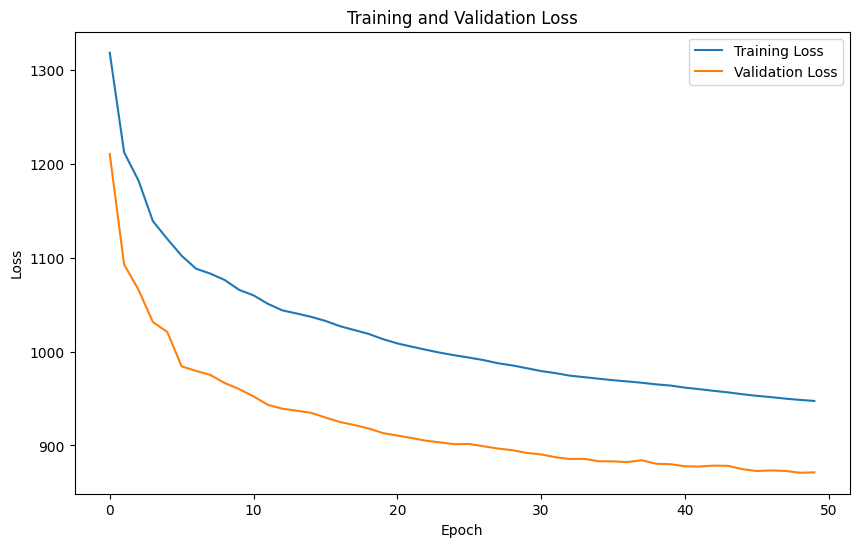

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#plt.savefig('train_valid_loss.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
if best_model_state is not None:
    # Current date and time
    now = datetime.datetime.now()
    date_time = now.strftime("%Y%m%d_%H%M%S")  # Format: YYYYMMDD_HHMMSS
    
    # Define your base path
    base_path = "states/"

    # Check if the directory exists, create it if it doesn't
    os.makedirs(base_path, exist_ok=True)
    
    # Combine base path with dynamically generated file name
    filename = f"best_model_{date_time}_epoch{best_epoch}_loss{best_val_loss:.4f}.pth"
    path = base_path + filename
    
    # Save the best model state
    torch.save(best_model_state, path)
    print(f'Saved best model to {path}')
else:
    print("No best model to save.")

In [ ]:
model.load_state_dict(torch.load('states/best_model_20240410_040503_epoch49_loss107.3928.pth'))
model = model.to(device)  # Ensure the model is on the correct device

In [ ]:
# After training, you can load the best model using:
if best_model_path:
    model.load_state_dict(torch.load(best_model_path))
    model = model.to(device)  # Ensure the model is on the correct device
    print(f"Loaded best model from {best_model_path}")

In [44]:
import torch

# Assuming 'train_loader' is your DataLoader for the training set
model.eval()
mus, logvars = [], []
with torch.no_grad():
    for data in train_loader:
        data = data[0]  # Assuming data[0] contains your input features
        mu, logvar = model.encoder(data)
        mus.append(mu)
        logvars.append(logvar)

In [47]:
all_mus = torch.cat(mus, dim=0)
all_logvars = torch.cat(logvars, dim=0)

In [53]:
import torch

M = 100  # Number of Monte Carlo simulations
s = len(test_loader)  # Assuming the loader provides one day's data per batch
latent_dim = 32  # Latent dimensionality

# Initialize an empty tensor for z_samples with the desired shape
z_samples = torch.empty((M, s, latent_dim), dtype=torch.float)


In [54]:
for day in range(s):
    # Randomly select an index to sample mu and logvar for each MC simulation
    random_indices = torch.randint(0, all_mus.shape[0], (M,))
    
    # Extract the mus and logvars for these indices
    mus = all_mus[random_indices]
    logvars = all_logvars[random_indices]
    
    # Calculate std from logvar
    stds = torch.exp(0.5 * logvars)
    
    # Sample eps from a standard normal distribution
    eps = torch.randn_like(stds)
    
    # Calculate z samples using the reparameterization trick
    z = mus + eps * stds
    
    # Store the generated z samples
    z_samples[:, day, :] = z


In [59]:
import torch

M = 100  # Number of Monte Carlo simulations
s = len(test_loader)  # Total days in the test set
latent_dim = all_mus.shape[1]  # Latent dimensionality

# Initialize an empty tensor for z_samples
z_samples = torch.empty((M, s, latent_dim), dtype=torch.float).to(all_mus.device)  # Ensure z_samples is on the same device

for mc_sim in range(M):
    for day in range(s):
        # Randomly select an index for mu and logvar
        random_index = torch.randint(0, all_mus.shape[0], (1,)).item()
        
        # Extract mu and logvar for this index
        mu = all_mus[random_index]
        logvar = all_logvars[random_index]
        
        # Calculate std from logvar
        std = torch.exp(0.5 * logvar)
        
        # Sample eps from a standard normal distribution
        eps = torch.randn_like(std)
        
        # Calculate z sample using the reparameterization trick
        z = mu + eps * std
        
        # Store the generated z sample
        z_samples[mc_sim, day, :] = z



In [61]:
# Same initial setup
M = 100  # Number of Monte Carlo simulations
s = len(test_loader)  # Total days in the test set
latent_dim = all_mus.shape[1]  # Latent dimensionality

# Randomly select indices for each day and MC simulation
random_indices = torch.randint(0, all_mus.shape[0], (M, s))

# Extract mus and logvars using advanced indexing
mus = all_mus[random_indices]
logvars = all_logvars[random_indices]

# Calculate stds from logvars
stds = torch.exp(0.5 * logvars)

# Sample eps from a standard normal distribution for all simulations and days at once
eps = torch.randn_like(stds)

# Calculate z samples using the reparameterization trick
z_samples = mus + eps * stds


In [65]:
# Assuming model's decoder method is accessible and it is designed to accept a single z sample at a time
# Initialize an empty tensor for the decoded samples with the correct shape
N = standardized_log_returns.shape[1]
decoded_samples = torch.empty((M, s, N), dtype=torch.float).to(device)  # Make sure it's on the correct device

# Decode each z sample
for mc_sim in range(M):
    for day in range(s):
        z = z_samples[mc_sim, day, :].unsqueeze(0)  # Add batch dimension
        decoded = model.decoder(z)  # Decode z to reconstruct the stock returns
        decoded_samples[mc_sim, day, :] = decoded.squeeze(0)  # Remove batch dimension and store the result


In [72]:
#Vectorized
N = standardized_log_returns.shape[1] 

# Flatten z_samples for batch processing
z_samples_flat = z_samples.view(-1, latent_dim)

# Decode in one go (assuming your model can handle this efficiently)
decoded_flat = model.decoder(z_samples_flat)

# Reshape decoded samples back to the desired shape
decoded_samples = decoded_flat.view(M, s, N)


In [84]:
rolling_mean.iloc[-639:, :]

,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,WYNN,XEL,XOM,YUM,ZBH,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-17,0.002125,0.000801,0.000330,0.001601,0.001332,0.000663,0.001967,0.001654,0.002010,0.000950,...,0.000023,0.001141,0.001399,0.001075,0.003157,-0.000024,0.003291,0.001406,0.001024,0.003679
2021-06-18,0.002013,0.000662,0.000076,0.001324,0.001215,0.000792,0.001827,0.001478,0.001801,0.001028,...,-0.000191,0.000964,0.001378,0.000879,0.003054,-0.000197,0.003139,0.001265,0.000845,0.003723
2021-06-21,0.002051,0.000693,0.000141,0.001411,0.001320,0.000707,0.001787,0.001572,0.001975,0.001062,...,-0.000266,0.001119,0.001443,0.000966,0.003174,-0.000262,0.003534,0.001335,0.000968,0.003711
2021-06-22,0.002126,0.000945,0.000228,0.001371,0.001391,0.001022,0.002009,0.001537,0.001945,0.001320,...,-0.000139,0.001067,0.001521,0.000884,0.003051,-0.000302,0.003665,0.001171,0.001051,0.003730
2021-06-23,0.001979,0.000765,0.000115,0.001253,0.001364,0.000921,0.001883,0.001381,0.001809,0.001191,...,-0.000234,0.000952,0.001227,0.000732,0.002966,-0.000423,0.003579,0.001208,0.000832,0.003496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.000062,0.000900,0.000213,0.000381,0.001276,0.002517,0.000287,-0.000539,0.000369,0.001151,...,0.000211,0.000593,0.000162,0.000782,-0.001044,-0.000769,-0.000674,-0.000089,-0.000383,-0.000602
2023-12-26,0.000072,0.000973,0.000289,0.000380,0.001261,0.002577,0.000226,-0.000559,0.000456,0.001181,...,0.000214,0.000594,0.000119,0.000718,-0.001049,-0.000712,-0.000637,-0.000036,-0.000300,-0.000509
2023-12-27,0.000052,0.001018,0.000339,0.000353,0.001176,0.002633,0.000284,-0.000668,0.000408,0.001192,...,0.000282,0.000580,0.000017,0.000659,-0.000973,-0.000798,-0.000702,-0.000031,-0.000451,-0.000542


In [91]:
import torch

s = 639  # Number of days in the test set
M = 100  # Number of Monte Carlo simulations
N = decoded_samples.shape[2]  # Assuming decoded_samples is already defined

# Subset rolling_mean and rolling_std for the last 's' days
subset_rolling_mean = rolling_mean.iloc[-s:, :].values  # Shape: (s, n_stocks)
subset_rolling_std = rolling_std.iloc[-s:, :].values  # Shape: (s, n_stocks)

# Convert to tensors and ensure they're on the correct device (e.g., 'cuda' or 'cpu')
subset_rolling_mean = torch.tensor(subset_rolling_mean, dtype=torch.float).to(device)  # Shape: (s, n_stocks)
subset_rolling_std = torch.tensor(subset_rolling_std, dtype=torch.float).to(device)  # Shape: (s, n_stocks)

# Initialize an empty tensor for the destandardized samples
destandardized_samples = torch.empty((M, s, N), dtype=torch.float).to(device)

# Perform elementwise destandardization for each MC simulation
for mc_sim in range(M):
    # Apply the destandardization formula: multiply by std and add the mean
    destandardized_samples[mc_sim, :, :] = (decoded_samples[mc_sim, :, :] * subset_rolling_std) + subset_rolling_mean


In [88]:
import torch

s = 639  # Number of days in the test set
M = 100  # Number of Monte Carlo simulations
N = decoded_samples.shape[2]  # Assuming decoded_samples is already defined

# Subset rolling_mean and rolling_std for the last 's' days
subset_rolling_mean = rolling_mean.iloc[-s:, :].values  # Shape: (s, n_stocks)
subset_rolling_std = rolling_std.iloc[-s:, :].values  # Shape: (s, n_stocks)

# Convert to tensors and ensure they're on the correct device (e.g., 'cuda' or 'cpu')
subset_rolling_mean = torch.tensor(subset_rolling_mean, dtype=torch.float).to(device)  # Shape: (s, n_stocks)
subset_rolling_std = torch.tensor(subset_rolling_std, dtype=torch.float).to(device)  # Shape: (s, n_stocks)

# Perform destandardization in a vectorized manner
# Expand subset_rolling_mean and subset_rolling_std to match decoded_samples shape for broadcasting
expanded_rolling_mean = subset_rolling_mean.unsqueeze(0).expand_as(decoded_samples)
expanded_rolling_std = subset_rolling_std.unsqueeze(0).expand_as(decoded_samples)

# Initialize an empty tensor for the destandardized samples
destandardized_samples = torch.empty((M, s, N), dtype=torch.float).to(device)

# Apply the destandardization formula: (decoded_samples * std) + mean
destandardized_samples = (decoded_samples * expanded_rolling_std) + expanded_rolling_mean


In [94]:
# Assuming weights_vector is defined with shape [n_stocks]
weights_tensor = torch.tensor(weights_vector, dtype=torch.float).to(device)  # Ensure it's on the correct device

# Calculate portfolio returns: Dot product across the n_stocks dimension
# The resulting shape of joint_returns will be [M, s]
joint_returns = torch.einsum('msn,n->ms', destandardized_samples, weights_tensor)


In [99]:
# Assuming destandardized_samples is a PyTorch tensor with shape [M, s, n_stocks]
# and weights_vector is a 1D PyTorch tensor or NumPy array with length n_stocks

# Convert destandardized_samples to a NumPy array
destandardized_samples_np = destandardized_samples.detach().numpy()

# Initialize an empty NumPy array for the joint returns
joint_returns_np = np.empty((destandardized_samples_np.shape[0], destandardized_samples_np.shape[1]))

# Perform the dot product for each Monte Carlo simulation
for mc_sim in range(destandardized_samples_np.shape[0]):
    joint_returns_np[mc_sim, :] = np.dot(destandardized_samples_np[mc_sim, :, :], weights_vector)

# Now, joint_returns_np has shape [M, s] and contains the portfolio returns for each Monte Carlo simulation and day


In [113]:
# Using np.matmul for vectorized matrix multiplication
joint_returns_np = np.matmul(destandardized_samples_np, weights_vector)


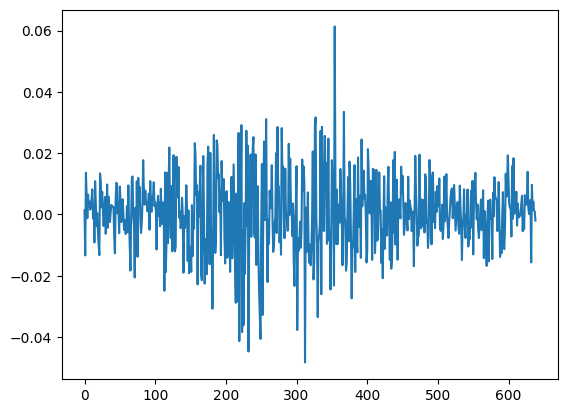

In [116]:
plt.plot(portfolio_returns[-639:])

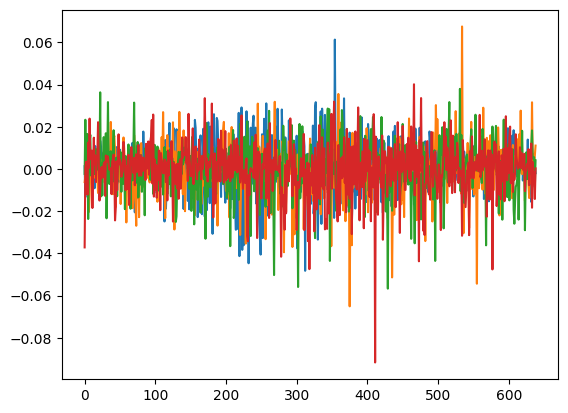

In [115]:
plt.plot(portfolio_returns[-639:])
plt.plot(joint_returns_np[0])
plt.plot(joint_returns_np[1])
plt.plot(joint_returns_np[2])

In [119]:
len(train_loader) + len(validation_loader) + len(test_loader)

5105

In [122]:
t = standardized_log_returns.shape[0]

In [124]:
len(portfolio_returns[-t:])

5105

In [118]:
aligned_returns = (portfolio_returns[-t:]

5284

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a pandas Series 'returns' with your daily returns
confidence_level = 0.95
rolling_window_size = 180  # Adjust as needed, considering you're looking at 1-day ahead VaR
t = standardized_log_returns.shape[0]

aligned_returns = pd.Series(portfolio_returns[-t:])

# Calculate the rolling VaR (95% confidence)
rolling_VaR_95 = aligned_returns.rolling(window=rolling_window_size).quantile(1 - confidence_level).shift(1)

In [ ]:
import pandas as pd
import numpy as np

# Assuming portfolio_returns is a 1D NumPy array
portfolio_returns_series = pd.Series(portfolio_returns.flatten())

# If portfolio_returns is 2D with shape [M, s] and you want to calculate VaR across all simulations,
# you might first mean or median aggregate the simulations, or flatten them as needed.


In [127]:
import numpy as np

def calculate_rolling_var(returns, window_size, confidence_level):
    """
    Calculate the rolling Value at Risk (VaR) for a numpy array of returns.

    Parameters:
    - returns: np.array of daily returns.
    - window_size: The rolling window size.
    - confidence_level: The confidence level for VaR (e.g., 0.95 for 95% confidence).

    Returns:
    - A numpy array containing the rolling VaR values. Initial values (less than window_size) will be NaN.
    """
    n = len(returns)
    rolling_var = np.full(n, np.nan)  # Initialize rolling VaR array with NaN
    
    for i in range(window_size, n):
        window_returns = returns[i-window_size:i]
        var = np.quantile(window_returns, 1 - confidence_level)
        rolling_var[i] = var
    
    return rolling_var


In [136]:
confidence_level = 0.95
rolling_window_size = 180

# Flatten the portfolio returns if it's not already 1D
portfolio_returns_flat = portfolio_returns.flatten()

# Calculate the rolling VaR
rolling_VaR_95 = calculate_rolling_var(portfolio_returns_flat, rolling_window_size, confidence_level)


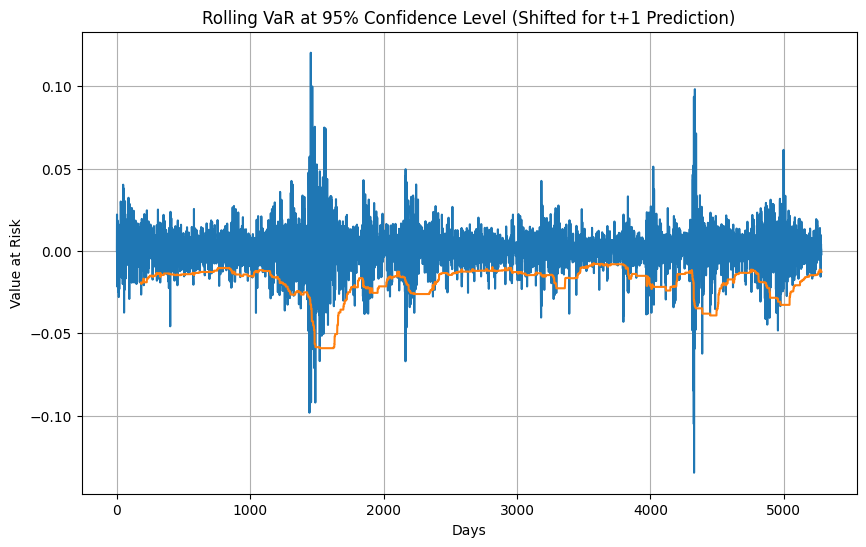

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming portfolio_returns is already defined as a 1D NumPy array
portfolio_returns_series = pd.Series(portfolio_returns.flatten())

confidence_level = 0.95
rolling_window_size = 180

# Calculate the rolling VaR and then shift the results by 1 to estimate the next period's VaR
rolling_VaR_95 = portfolio_returns_series.rolling(window=rolling_window_size).quantile(1 - confidence_level).shift(1)

# Plotting the rolling VaR with the shift
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns)
plt.plot(rolling_VaR_95)
plt.title("Rolling VaR at 95% Confidence Level (Shifted for t+1 Prediction)")
plt.xlabel("Days")
plt.ylabel("Value at Risk")
plt.grid(True)
plt.show()


In [173]:
import pandas as pd
import numpy as np

confidence_level = 0.95
rolling_window_size = 180
s = len(test_loader)  # Assuming this gives the length of the test set
M = joint_returns.shape[0]  # Number of Monte Carlo simulations

# Extract the last 180 days of portfolio returns from the validation set
historical_context = portfolio_returns[-(rolling_window_size + s):-s]

# Initialize a container for the rolling VaR values for each simulation
rolling_VaR_95_per_simulation = np.empty((M, s))

for i in range(M):
    # Concatenate the historical context with the current simulation's returns
    concatenated_returns = np.concatenate([historical_context, joint_returns_np[i, :]])
    
    # Convert to a Pandas Series
    concatenated_series = pd.Series(concatenated_returns)
    
    # Calculate rolling VaR for the concatenated series
    rolling_VaR_95_path = concatenated_series.rolling(window=rolling_window_size).quantile(1 - confidence_level).shift(1)
    
    # Extract the VaR values corresponding to the simulation's returns
    simulation_VaR_95 = rolling_VaR_95_path[-s:].values  # Focus on the last 's' values
    
    # Store the rolling VaR values for the current simulation
    rolling_VaR_95_per_simulation[i, :] = simulation_VaR_95

# `rolling_VaR_95_per_simulation` now holds the rolling VaR paths for each simulation


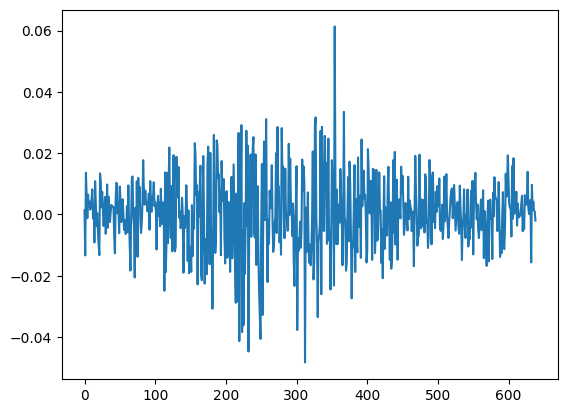

In [170]:
plt.plot(portfolio_returns[-s:])

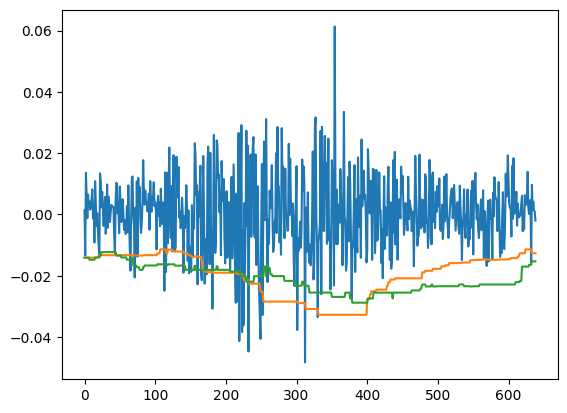

In [179]:
plt.plot(range(s), portfolio_returns[-s:])
plt.plot(range(s), rolling_VaR_95[-s:])
plt.plot(range(s), rolling_VaR_95_per_simulation[0,:])

In [181]:
import pandas as pd
import numpy as np

confidence_level = 0.95
rolling_window_size = 180
s = len(test_loader)  # Assuming this gives the length of the test set
M = joint_returns_np.shape[0]  # Number of Monte Carlo simulations

# Extract the last 180 days of portfolio returns from the validation set
historical_context = portfolio_returns[-(rolling_window_size + s):-s]

# Initialize containers for the rolling VaR values for each simulation
rolling_VaR_95_per_simulation = np.empty((M, s))

# For average and worst VaR calculation
average_VaR_95_per_day = np.empty(s)
worst_VaR_95_per_day = np.empty(s)

for i in range(M):
    # Concatenate the historical context with the current simulation's returns
    concatenated_returns = np.concatenate([historical_context, joint_returns_np[i, :]])
    
    # Calculate rolling VaR for the concatenated series using Pandas
    rolling_VaR_95_path = pd.Series(concatenated_returns).rolling(window=rolling_window_size).quantile(1 - confidence_level).shift(1)[-s:]
    
    # Store the rolling VaR values for the current simulation
    rolling_VaR_95_per_simulation[i, :] = rolling_VaR_95_path.values

# Calculate the average and worst VaR for each test day across all simulations
average_VaR_95_per_day = np.mean(rolling_VaR_95_per_simulation, axis=0)
worst_VaR_95_per_day = np.min(rolling_VaR_95_per_simulation, axis=0)


In [ ]:
test_returns = portfolio_returns[-s:]
test_rolling_VaR_95 = rolling_VaR_95[-s:]

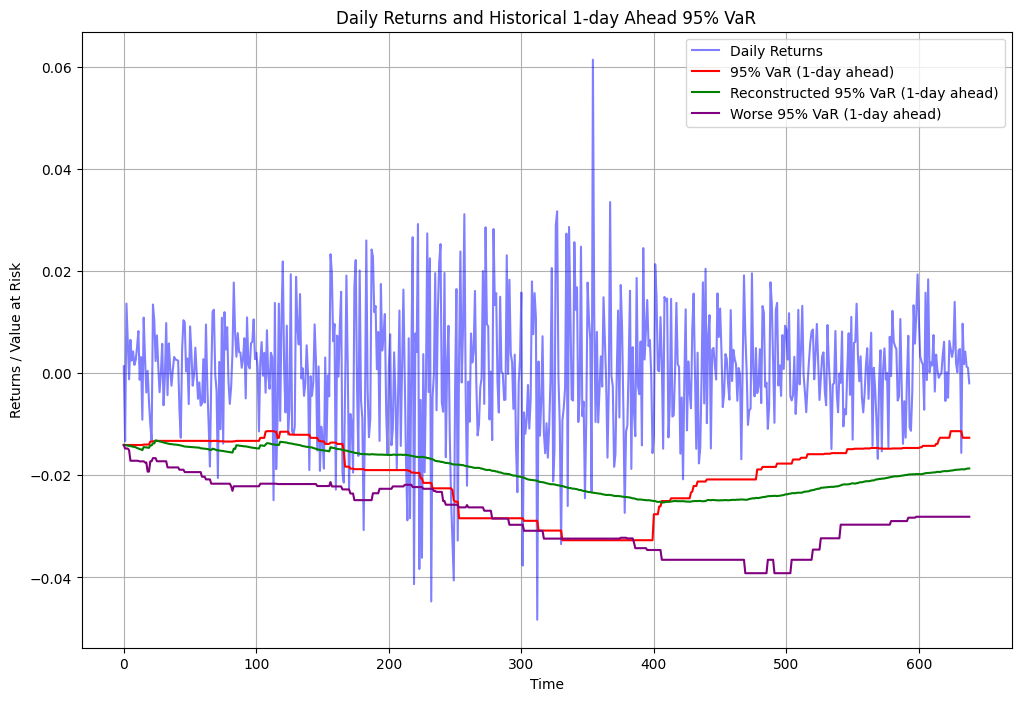

In [194]:
# Plotting
plt.figure(figsize=(12, 8))
x_index = np.arange(s)
# Plot returns
plt.plot(x_index, test_returns, label='Daily Returns', color='blue', alpha=0.5)

# Plot VaR
plt.plot(x_index, test_rolling_VaR_95, label='95% VaR (1-day ahead)', color='red', linestyle='-')
plt.plot(x_index, average_VaR_95_per_day, label='Reconstructed 95% VaR (1-day ahead)', color='green', linestyle='-')
plt.plot(x_index, worst_VaR_95_per_day, label='Worse 95% VaR (1-day ahead)', color='purple', linestyle='-')


plt.title('Daily Returns and Historical 1-day Ahead 95% VaR')
plt.xlabel('Time')
plt.ylabel('Returns / Value at Risk')
plt.legend()
plt.grid(True)
plt.show()

In [190]:
breaches = portfolio_returns[-s:] < rolling_VaR_95[-s:]

# Calculate the number of breaches
num_breaches = np.sum(breaches)

# Calculate the expected number of breaches at a 95% confidence level
expected_breaches = len(rolling_VaR_95[-s:]) * 0.05

num_breaches, expected_breaches

(33, 31.950000000000003)

In [191]:
breaches = portfolio_returns[-s:] < worst_VaR_95_per_day

# Calculate the number of breaches
num_breaches = np.sum(breaches)

# Calculate the expected number of breaches at a 95% confidence level
expected_breaches = len(worst_VaR_95_per_day) * 0.05

num_breaches, expected_breaches

(15, 31.950000000000003)

In [192]:
breaches = portfolio_returns[-s:] < average_VaR_95_per_day

# Calculate the number of breaches
num_breaches = np.sum(breaches)

# Calculate the expected number of breaches at a 95% confidence level
expected_breaches = len(average_VaR_95_per_day) * 0.05

num_breaches, expected_breaches

(36, 31.950000000000003)

In [193]:
test_returns = portfolio_returns[-s:]
test_rolling_VaR_95 = rolling_VaR_95[-s:]

In [195]:
# Regulatory Loss Function (RQLt)
RQLt = np.where(test_returns < test_rolling_VaR_95, 1 + (test_rolling_VaR_95 - test_returns) ** 2, 0)

# Linear Loss Function (LLt)
LLt = np.abs(test_returns - test_rolling_VaR_95)

# Quadratic Loss Function (QLt)
QLt = (test_returns - test_rolling_VaR_95) ** 2

In [196]:
# Regulatory Loss Function (RQLt)
RQLt_avg = np.where(test_returns < average_VaR_95_per_day, 1 + (average_VaR_95_per_day - test_returns) ** 2, 0)

# Linear Loss Function (LLt)
LLt_avg = np.abs(test_returns - average_VaR_95_per_day)

# Quadratic Loss Function (QLt)
QLt_avg = (test_returns - average_VaR_95_per_day) ** 2

In [197]:
# Regulatory Loss Function (RQLt)
RQLt_worst = np.where(test_returns < worst_VaR_95_per_day, 1 + (worst_VaR_95_per_day - test_returns) ** 2, 0)

# Linear Loss Function (LLt)
LLt_worst = np.abs(test_returns - worst_VaR_95_per_day)

# Quadratic Loss Function (QLt)
QLt_worst = (test_returns - worst_VaR_95_per_day) ** 2

In [199]:
np.sum(RQLt), np.sum(RQLt_avg), np.sum(RQLt_worst)

(33.003437911731076, 36.0054763296576, 15.002117019108278)

In [200]:
np.sum(LLt), np.sum(LLt_avg), np.sum(LLt_worst)

(13.408110844984542, 13.305005824798736, 18.456814621963378)

In [201]:
np.sum(QLt), np.sum(QLt_avg), np.sum(QLt_worst)

(0.38467944346593075, 0.3557240041955654, 0.6386772204127333)

In [203]:
test_data

,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,WYNN,XEL,XOM,YUM,ZBH,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-17,1.501073,0.608367,0.890978,-1.355710,0.118438,0.759938,-0.040558,-2.256037,-0.046284,0.427441,...,0.365547,-1.081704,0.976416,-0.580004,-0.140621,0.686269,-1.521142,-1.003088,0.825092,-0.655812
2021-06-18,-1.086317,-0.561171,-0.768297,-2.109678,-1.016597,1.332739,-1.393210,-1.449726,-1.815453,0.242722,...,-1.641714,-1.780241,-0.040146,-1.028927,-0.321084,-2.009612,-1.200163,-1.619334,-0.757121,-1.083681
2021-06-21,0.543326,0.690813,0.642402,1.070428,1.031396,0.129841,0.541012,1.151260,1.170183,0.873392,...,0.835397,1.235178,0.844870,1.265707,0.708914,0.654581,1.325096,1.350484,1.776984,0.910828
2021-06-22,-0.045010,0.610314,-0.297162,0.084405,-0.077499,0.749209,-0.265356,-0.310719,-0.022698,0.435073,...,0.428209,-0.151521,0.341255,-0.245651,-0.313980,-0.433466,0.632498,0.417854,0.979745,0.043237
2021-06-23,0.158534,-0.150367,-0.078645,0.483834,-0.091198,-0.194932,-0.114702,-0.494199,-0.699949,-0.481612,...,-0.686522,-0.547606,-0.327400,-0.362999,-0.302405,-0.582030,0.155508,-0.487024,-0.737731,-0.545150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.260340,-0.539718,0.384127,-0.305922,1.215987,-0.246148,0.238621,0.564678,0.623433,0.143380,...,1.166827,0.427147,0.198145,0.464003,-0.118010,0.807993,0.167954,0.023014,0.568264,0.583703
2023-12-26,0.096050,-0.320603,0.122746,-0.315870,-0.337166,-0.173044,0.537462,0.955572,0.478389,0.486955,...,-0.174692,-0.158230,0.420361,0.507960,0.387337,0.326017,0.198875,0.192923,0.528859,0.835800
2023-12-27,0.001149,-0.042092,0.379524,0.003563,-0.005958,-0.320770,0.131252,-0.168992,-0.334281,-0.060437,...,0.905435,-0.094695,-0.260448,0.221173,-0.161709,-0.921549,-0.275926,0.424318,-0.139769,0.058273


In [233]:
import torch

# Set your model to evaluation mode
model.eval()

# Assuming you have a DataLoader for your training set called 'train_loader'
# And your model's forward pass returns the reconstruction as its first output

# Collect all reconstructions in a list
reconstructions = []

with torch.no_grad():  # Turn off gradients for this part to save memory and computations
    for batch in train_loader:
        inputs = batch[0]  # Ensure data is on the correct device
        recon, _, _ = model(inputs)   # Forward pass (ignore mu and logvar for now)
        reconstructions.append(recon.cpu())  # Move reconstructions to CPU and store

# Concatenate all reconstructions along the batch dimension
reconstructed_output = torch.cat(reconstructions, dim=0)


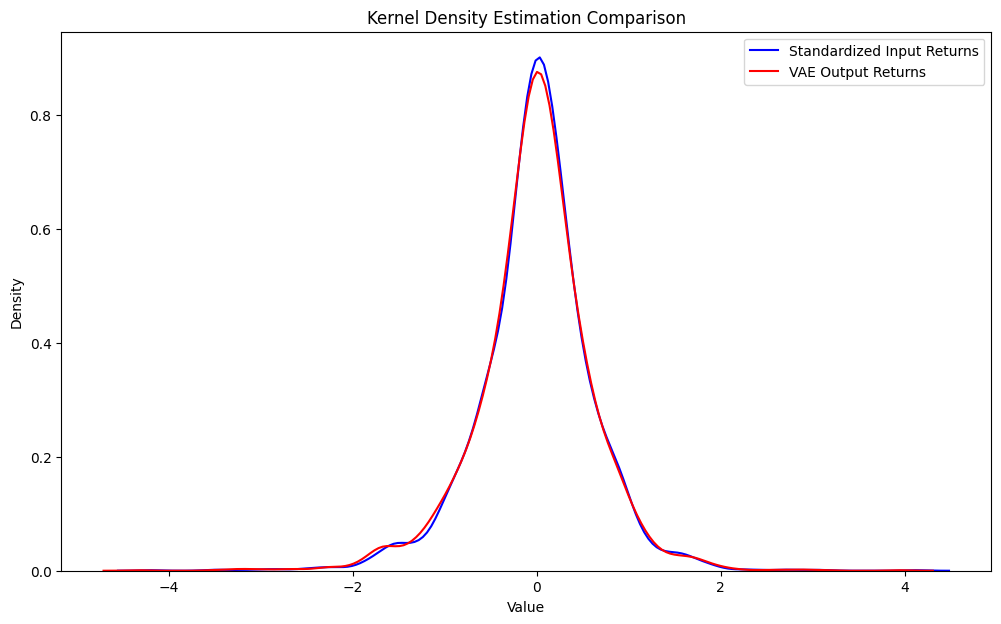

In [236]:
reconstructed_returns = np.dot(reconstructed_output, weights_vector)
standardized_train_returns = np.dot(train_data, weights_vector)

plt.figure(figsize=(12, 7))
sns.kdeplot(standardized_train_returns, label="Standardized Input Returns", color='blue')
sns.kdeplot(reconstructed_returns, label="VAE Output Returns", color='red')
# Add title and labels, and show the plot
plt.title('Kernel Density Estimation Comparison')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


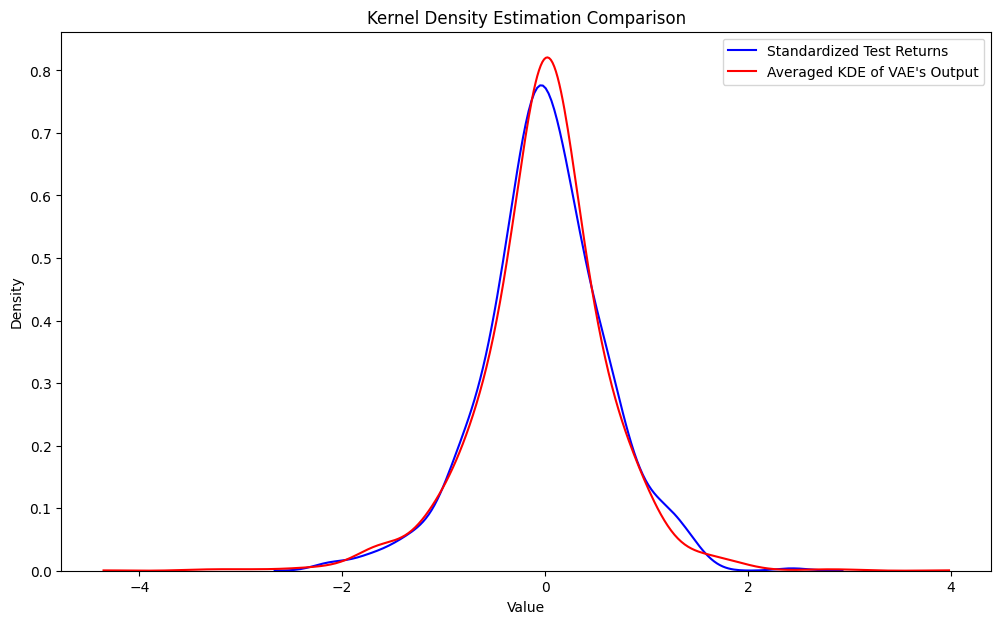

In [225]:
import numpy as np
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt

# Parameters
M = 100  # Number of Monte Carlo simulations
s = len(test_loader)  # Length of the test set

# Assuming weighted_decoded_samples is a NumPy array with shape (M, s)
# And assuming standardized_test_returns is a 1D NumPy array with length s
weighted_decoded_samples = np.dot(decoded_samples.detach().numpy(), weights_vector)
standardized_test_returns = np.dot(test_data, weights_vector)

# Step 1: Compute KDEs for Each Monte Carlo Simulation
kdes = [gaussian_kde(weighted_decoded_samples[mc_simulation, :]) for mc_simulation in range(M)]

# Step 2: Evaluate KDEs Over a Consistent Range
x = np.linspace(np.min(weighted_decoded_samples), np.max(weighted_decoded_samples), num=500)
kde_values = np.array([kde(x) for kde in kdes])

# Step 3: Average the KDE Values
average_kde_values = np.mean(kde_values, axis=0)

# Step 4: Plot the Averaged KDE Against the Standardized Test Returns
plt.figure(figsize=(12, 7))
sns.kdeplot(standardized_test_returns, label="Standardized Test Returns", color='blue')
plt.plot(x, average_kde_values, label="Averaged KDE of VAE's Output", color='red')

# Add title and labels, and show the plot
plt.title('Kernel Density Estimation Comparison')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()
